<a href="https://colab.research.google.com/github/flaviorv/pb_ai_ml/blob/main/nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

83987 Token IDs to 20 components

Cross Validation results of Grid Search
       mean  neighbors
0  0.937946          3
1  0.942313          7
2  0.939865         20
3  0.936888         50
4  0.933580        100
Best params: {'n_neighbors': 7}
Best score: 0.9423128151543633

Results of test data
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1878
           1       0.93      0.94      0.94      1902

    accuracy                           0.94      3780
   macro avg       0.94      0.94      0.94      3780
weighted avg       0.94      0.94      0.94      3780

Specificity 0: 0.94
Specificity 1: 0.93



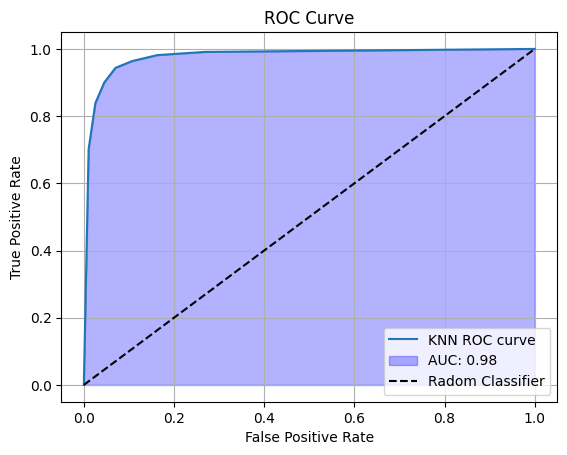

In [82]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# getting data (true/fake tweets)
col_names = ['title', 'tweet', 'type', 'date']
fake_df = pd.read_csv('https://raw.githubusercontent.com/professortiagoinfnet/inteligencia_artificial/refs/heads/main/Fake.csv', names=col_names, header=0)
true_df = pd.read_csv('https://raw.githubusercontent.com/professortiagoinfnet/inteligencia_artificial/refs/heads/main/True.csv', names=col_names, header=0)

# creating the target column of each class
fake_df['target'] = 0
true_df['target'] = 1

# concatenating the two data types
all = pd.concat([fake_df, true_df], ignore_index=True)
# shuffling the samples
all = all.sample(frac=1, random_state=42)
# x and y split
x = all['tweet']
y = all['target']

# question 1 (features creation with Term frequency - Inverse Document Frequency)
vectorizer = TfidfVectorizer()
x_vec = vectorizer.fit_transform(x)

# transforming in components to reduce the dimensionality
svd = TruncatedSVD(n_components=20, random_state=42)
x_reduced = svd.fit_transform(x_vec)
print(f'{x_vec.shape[1]} Token IDs to {x_reduced.shape[1]} components', end='\n\n')

# split train / test
x_train, x_test, y_train, y_test = train_test_split(x_reduced, y, test_size=0.20, random_state=42)

# question 2 (KNN model with different hyperparam to select the best)
knn_param_grid = {
    'n_neighbors': [3, 7, 20, 50, 100]
}
knn = KNeighborsClassifier()

# questions 2 and 3 (the Grid Search runs the cross validation with 5 k-folds by default and returns the best hyperparam)
grid_search = GridSearchCV(knn, knn_param_grid, n_jobs=-1)
grid_search.fit(x_train, y_train)
print('Cross Validation results of Grid Search')
# mean of folds to each hyperparam
results = grid_search.cv_results_
results_df = pd.DataFrame()
results_df['mean'] = results['mean_test_score']
results_df['neighbors'] = results['param_n_neighbors']
print(results_df)
# best result
print(f'Best params: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}', end='\n\n')

# using the model with the best hyperparameters
y_pred = grid_search.best_estimator_.predict(x_test)
print('Results of test data')

# question 4 (getting recall, f1-score, precision and accuracy scores)
print(classification_report(y_test, y_pred))
# has no specificity in classification_report, so it's created manually
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity0 = tp/(tp+fn)
specificity1 = tn/(tn+fp)
print(f'Specificity 0: {specificity0:.2f}')
print(f'Specificity 1: {specificity1:.2f}', end='\n\n')

# question 4 (ROC Curve chart with Area Under the Curve metric)
y_proba = grid_search.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='KNN ROC curve')
plt.fill_between(fpr, tpr, alpha=0.3, color='blue', label=f'AUC: {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Radom Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()